<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[10:06:56] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


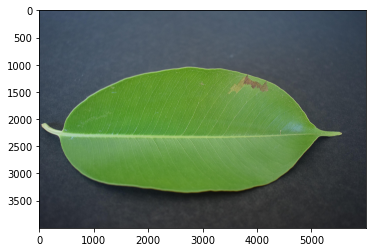

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

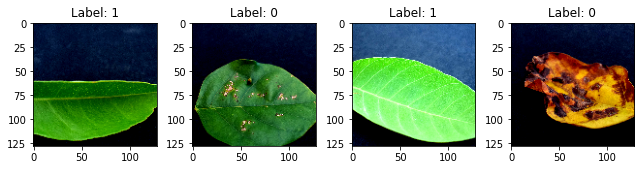

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[10:07:04] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[10:07:06] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.251100282185589 samples/sec                   batch loss = 0.6491703391075134 | accuracy = 0.7


Epoch[1] Batch[10] Speed: 1.2640574191273979 samples/sec                   batch loss = 0.616519570350647 | accuracy = 0.65


Epoch[1] Batch[15] Speed: 1.2549984605390836 samples/sec                   batch loss = 0.35745131969451904 | accuracy = 0.6166666666666667


Epoch[1] Batch[20] Speed: 1.2548767118390038 samples/sec                   batch loss = 0.5063915252685547 | accuracy = 0.5625


Epoch[1] Batch[25] Speed: 1.2462533584041684 samples/sec                   batch loss = 1.814332127571106 | accuracy = 0.57


Epoch[1] Batch[30] Speed: 1.249805458369581 samples/sec                   batch loss = 0.8562933802604675 | accuracy = 0.5833333333333334


Epoch[1] Batch[35] Speed: 1.255033759876241 samples/sec                   batch loss = 1.0439430475234985 | accuracy = 0.6


Epoch[1] Batch[40] Speed: 1.2558823861862352 samples/sec                   batch loss = 0.7201471924781799 | accuracy = 0.575


Epoch[1] Batch[45] Speed: 1.2532729072882816 samples/sec                   batch loss = 1.1595951318740845 | accuracy = 0.5777777777777777


Epoch[1] Batch[50] Speed: 1.257603542383025 samples/sec                   batch loss = 0.2938389778137207 | accuracy = 0.595


Epoch[1] Batch[55] Speed: 1.2592518202510785 samples/sec                   batch loss = 0.5537034273147583 | accuracy = 0.6136363636363636


Epoch[1] Batch[60] Speed: 1.2584899155576665 samples/sec                   batch loss = 0.4557510018348694 | accuracy = 0.6125


Epoch[1] Batch[65] Speed: 1.261835601567132 samples/sec                   batch loss = 0.6763321161270142 | accuracy = 0.6269230769230769


Epoch[1] Batch[70] Speed: 1.2621994744526954 samples/sec                   batch loss = 0.824211835861206 | accuracy = 0.6178571428571429


Epoch[1] Batch[75] Speed: 1.2574841152577247 samples/sec                   batch loss = 0.7323304414749146 | accuracy = 0.6166666666666667


Epoch[1] Batch[80] Speed: 1.2544242803527774 samples/sec                   batch loss = 0.47312644124031067 | accuracy = 0.621875


Epoch[1] Batch[85] Speed: 1.2568785627613484 samples/sec                   batch loss = 0.2824607491493225 | accuracy = 0.6352941176470588


Epoch[1] Batch[90] Speed: 1.2660674814259796 samples/sec                   batch loss = 0.4372970163822174 | accuracy = 0.6416666666666667


Epoch[1] Batch[95] Speed: 1.2618395875581827 samples/sec                   batch loss = 0.5292906761169434 | accuracy = 0.6447368421052632


Epoch[1] Batch[100] Speed: 1.261487588789665 samples/sec                   batch loss = 1.4398300647735596 | accuracy = 0.6475


Epoch[1] Batch[105] Speed: 1.26659155443367 samples/sec                   batch loss = 0.6538338661193848 | accuracy = 0.6452380952380953


Epoch[1] Batch[110] Speed: 1.2648902589700728 samples/sec                   batch loss = 0.632735550403595 | accuracy = 0.6386363636363637


Epoch[1] Batch[115] Speed: 1.2655433646123269 samples/sec                   batch loss = 0.5464892387390137 | accuracy = 0.6347826086956522


Epoch[1] Batch[120] Speed: 1.2608108043113357 samples/sec                   batch loss = 0.5133281946182251 | accuracy = 0.6291666666666667


Epoch[1] Batch[125] Speed: 1.2588661241589034 samples/sec                   batch loss = 1.241528034210205 | accuracy = 0.632


Epoch[1] Batch[130] Speed: 1.2677390889473346 samples/sec                   batch loss = 0.8867743611335754 | accuracy = 0.6307692307692307


Epoch[1] Batch[135] Speed: 1.2628407733119724 samples/sec                   batch loss = 0.4139100909233093 | accuracy = 0.6388888888888888


Epoch[1] Batch[140] Speed: 1.2593021992881435 samples/sec                   batch loss = 0.5441569685935974 | accuracy = 0.6482142857142857


Epoch[1] Batch[145] Speed: 1.2539511809165094 samples/sec                   batch loss = 0.38691869378089905 | accuracy = 0.6517241379310345


Epoch[1] Batch[150] Speed: 1.2530130703929303 samples/sec                   batch loss = 0.6761517524719238 | accuracy = 0.6516666666666666


Epoch[1] Batch[155] Speed: 1.2512174732951626 samples/sec                   batch loss = 0.44094884395599365 | accuracy = 0.6532258064516129


Epoch[1] Batch[160] Speed: 1.25453233884305 samples/sec                   batch loss = 0.6900702714920044 | accuracy = 0.6484375


Epoch[1] Batch[165] Speed: 1.2504104568355325 samples/sec                   batch loss = 0.7260698080062866 | accuracy = 0.6454545454545455


Epoch[1] Batch[170] Speed: 1.258304632401951 samples/sec                   batch loss = 0.49593019485473633 | accuracy = 0.6441176470588236


Epoch[1] Batch[175] Speed: 1.2586633552875746 samples/sec                   batch loss = 0.6085774898529053 | accuracy = 0.6471428571428571


Epoch[1] Batch[180] Speed: 1.2497032393392606 samples/sec                   batch loss = 0.5478421449661255 | accuracy = 0.6486111111111111


Epoch[1] Batch[185] Speed: 1.2480538510784513 samples/sec                   batch loss = 0.6454195976257324 | accuracy = 0.6445945945945946


Epoch[1] Batch[190] Speed: 1.2619366826889518 samples/sec                   batch loss = 0.7116482853889465 | accuracy = 0.6434210526315789


Epoch[1] Batch[195] Speed: 1.2626170522828262 samples/sec                   batch loss = 0.5769108533859253 | accuracy = 0.6435897435897436


Epoch[1] Batch[200] Speed: 1.263955045757793 samples/sec                   batch loss = 0.48644405603408813 | accuracy = 0.64625


Epoch[1] Batch[205] Speed: 1.263016840660172 samples/sec                   batch loss = 0.39749571681022644 | accuracy = 0.6475609756097561


Epoch[1] Batch[210] Speed: 1.263494332837341 samples/sec                   batch loss = 0.7703315019607544 | accuracy = 0.6511904761904762


Epoch[1] Batch[215] Speed: 1.2648148303114095 samples/sec                   batch loss = 0.8640775680541992 | accuracy = 0.6534883720930232


Epoch[1] Batch[220] Speed: 1.2559206497735524 samples/sec                   batch loss = 0.789371132850647 | accuracy = 0.6522727272727272


Epoch[1] Batch[225] Speed: 1.2585103066443868 samples/sec                   batch loss = 0.5301499366760254 | accuracy = 0.6555555555555556


Epoch[1] Batch[230] Speed: 1.2632461250196239 samples/sec                   batch loss = 0.43724367022514343 | accuracy = 0.6565217391304348


Epoch[1] Batch[235] Speed: 1.2574050437953852 samples/sec                   batch loss = 0.7482733726501465 | accuracy = 0.6553191489361702


Epoch[1] Batch[240] Speed: 1.257559803218448 samples/sec                   batch loss = 0.43512648344039917 | accuracy = 0.65625


Epoch[1] Batch[245] Speed: 1.260666421604946 samples/sec                   batch loss = 0.3148396909236908 | accuracy = 0.6571428571428571


Epoch[1] Batch[250] Speed: 1.2564102909738974 samples/sec                   batch loss = 0.5295271873474121 | accuracy = 0.657


Epoch[1] Batch[255] Speed: 1.2542641028882542 samples/sec                   batch loss = 0.6442121863365173 | accuracy = 0.6568627450980392


Epoch[1] Batch[260] Speed: 1.257514087731634 samples/sec                   batch loss = 0.9812273979187012 | accuracy = 0.6557692307692308


Epoch[1] Batch[265] Speed: 1.2612567614918768 samples/sec                   batch loss = 0.3890915513038635 | accuracy = 0.6556603773584906


Epoch[1] Batch[270] Speed: 1.2601239557843917 samples/sec                   batch loss = 0.812404215335846 | accuracy = 0.6546296296296297


Epoch[1] Batch[275] Speed: 1.2586106668525139 samples/sec                   batch loss = 0.3729895055294037 | accuracy = 0.6545454545454545


Epoch[1] Batch[280] Speed: 1.2629990605732633 samples/sec                   batch loss = 0.5223532915115356 | accuracy = 0.6571428571428571


Epoch[1] Batch[285] Speed: 1.256867546130498 samples/sec                   batch loss = 0.2930014133453369 | accuracy = 0.6587719298245615


Epoch[1] Batch[290] Speed: 1.2590391007017945 samples/sec                   batch loss = 2.0006051063537598 | accuracy = 0.6560344827586206


Epoch[1] Batch[295] Speed: 1.2601496056309043 samples/sec                   batch loss = 0.883216142654419 | accuracy = 0.6542372881355932


Epoch[1] Batch[300] Speed: 1.2557669514567031 samples/sec                   batch loss = 0.44952335953712463 | accuracy = 0.655


Epoch[1] Batch[305] Speed: 1.2536800082197668 samples/sec                   batch loss = 0.425042062997818 | accuracy = 0.6581967213114754


Epoch[1] Batch[310] Speed: 1.2695406632944857 samples/sec                   batch loss = 0.24532803893089294 | accuracy = 0.657258064516129


Epoch[1] Batch[315] Speed: 1.258437430429416 samples/sec                   batch loss = 0.572792112827301 | accuracy = 0.6555555555555556


Epoch[1] Batch[320] Speed: 1.259991463981283 samples/sec                   batch loss = 0.17578811943531036 | accuracy = 0.65625


Epoch[1] Batch[325] Speed: 1.263318037218947 samples/sec                   batch loss = 0.5929259061813354 | accuracy = 0.6569230769230769


Epoch[1] Batch[330] Speed: 1.263372832961701 samples/sec                   batch loss = 0.5093801021575928 | accuracy = 0.6568181818181819


Epoch[1] Batch[335] Speed: 1.2540140715056123 samples/sec                   batch loss = 0.7426619529724121 | accuracy = 0.6582089552238806


Epoch[1] Batch[340] Speed: 1.2637997555896827 samples/sec                   batch loss = 0.5621233582496643 | accuracy = 0.6573529411764706


Epoch[1] Batch[345] Speed: 1.2680305623401662 samples/sec                   batch loss = 0.6615509390830994 | accuracy = 0.6557971014492754


Epoch[1] Batch[350] Speed: 1.2621289238655748 samples/sec                   batch loss = 0.4104990065097809 | accuracy = 0.6557142857142857


Epoch[1] Batch[355] Speed: 1.2616123313817458 samples/sec                   batch loss = 0.25892630219459534 | accuracy = 0.6577464788732394


Epoch[1] Batch[360] Speed: 1.259289155173246 samples/sec                   batch loss = 0.845888614654541 | accuracy = 0.6555555555555556


Epoch[1] Batch[365] Speed: 1.2614647298942314 samples/sec                   batch loss = 0.7293059229850769 | accuracy = 0.6568493150684932


Epoch[1] Batch[370] Speed: 1.257635028923659 samples/sec                   batch loss = 0.517446756362915 | accuracy = 0.6574324324324324


Epoch[1] Batch[375] Speed: 1.2615429847360302 samples/sec                   batch loss = 0.42474275827407837 | accuracy = 0.658


Epoch[1] Batch[380] Speed: 1.2595878197016008 samples/sec                   batch loss = 0.65528804063797 | accuracy = 0.6578947368421053


Epoch[1] Batch[385] Speed: 1.2615225901145786 samples/sec                   batch loss = 0.5076828002929688 | accuracy = 0.6590909090909091


Epoch[1] Batch[390] Speed: 1.2590079217346455 samples/sec                   batch loss = 0.6012662053108215 | accuracy = 0.6615384615384615


Epoch[1] Batch[395] Speed: 1.2618072258347885 samples/sec                   batch loss = 0.7655889391899109 | accuracy = 0.660759493670886


Epoch[1] Batch[400] Speed: 1.26102573430484 samples/sec                   batch loss = 0.6054501533508301 | accuracy = 0.66125


Epoch[1] Batch[405] Speed: 1.2600944266268637 samples/sec                   batch loss = 0.5257623195648193 | accuracy = 0.6617283950617284


Epoch[1] Batch[410] Speed: 1.2490639585920937 samples/sec                   batch loss = 0.7225505113601685 | accuracy = 0.6628048780487805


Epoch[1] Batch[415] Speed: 1.2512016101564911 samples/sec                   batch loss = 0.2713247835636139 | accuracy = 0.6638554216867469


Epoch[1] Batch[420] Speed: 1.2675646714471909 samples/sec                   batch loss = 0.4735048711299896 | accuracy = 0.6654761904761904


Epoch[1] Batch[425] Speed: 1.2619868970784218 samples/sec                   batch loss = 0.4455949068069458 | accuracy = 0.6664705882352941


Epoch[1] Batch[430] Speed: 1.2601196020395693 samples/sec                   batch loss = 0.38124990463256836 | accuracy = 0.6651162790697674


Epoch[1] Batch[435] Speed: 1.2629329838889856 samples/sec                   batch loss = 0.5606411695480347 | accuracy = 0.6655172413793103


Epoch[1] Batch[440] Speed: 1.263413932888334 samples/sec                   batch loss = 0.25384804606437683 | accuracy = 0.6676136363636364


Epoch[1] Batch[445] Speed: 1.2691081258335104 samples/sec                   batch loss = 0.3284214735031128 | accuracy = 0.6691011235955057


Epoch[1] Batch[450] Speed: 1.2625190923735632 samples/sec                   batch loss = 0.9714652895927429 | accuracy = 0.6694444444444444


Epoch[1] Batch[455] Speed: 1.2670972088270458 samples/sec                   batch loss = 0.6198328137397766 | accuracy = 0.6692307692307692


Epoch[1] Batch[460] Speed: 1.2663242545411069 samples/sec                   batch loss = 0.7257096767425537 | accuracy = 0.6711956521739131


Epoch[1] Batch[465] Speed: 1.2581849777332548 samples/sec                   batch loss = 0.4562150537967682 | accuracy = 0.6725806451612903


Epoch[1] Batch[470] Speed: 1.262607835232288 samples/sec                   batch loss = 0.35562649369239807 | accuracy = 0.674468085106383


Epoch[1] Batch[475] Speed: 1.2610494303665694 samples/sec                   batch loss = 0.39318108558654785 | accuracy = 0.6731578947368421


Epoch[1] Batch[480] Speed: 1.262411933472944 samples/sec                   batch loss = 0.42873167991638184 | accuracy = 0.6739583333333333


Epoch[1] Batch[485] Speed: 1.2663206224870347 samples/sec                   batch loss = 0.719426155090332 | accuracy = 0.6731958762886598


Epoch[1] Batch[490] Speed: 1.2620390141583955 samples/sec                   batch loss = 0.6979342699050903 | accuracy = 0.6744897959183673


Epoch[1] Batch[495] Speed: 1.2605334368775176 samples/sec                   batch loss = 0.24307221174240112 | accuracy = 0.6757575757575758


Epoch[1] Batch[500] Speed: 1.265940901082974 samples/sec                   batch loss = 0.3974311053752899 | accuracy = 0.676


Epoch[1] Batch[505] Speed: 1.2610564445716568 samples/sec                   batch loss = 0.4823361933231354 | accuracy = 0.6752475247524753


Epoch[1] Batch[510] Speed: 1.269338859026062 samples/sec                   batch loss = 0.525185227394104 | accuracy = 0.6740196078431373


Epoch[1] Batch[515] Speed: 1.2588997521401846 samples/sec                   batch loss = 0.379011869430542 | accuracy = 0.6762135922330097


Epoch[1] Batch[520] Speed: 1.2567549427579727 samples/sec                   batch loss = 0.30978524684906006 | accuracy = 0.6764423076923077


Epoch[1] Batch[525] Speed: 1.256915851252663 samples/sec                   batch loss = 0.8368956446647644 | accuracy = 0.6771428571428572


Epoch[1] Batch[530] Speed: 1.2655899521734306 samples/sec                   batch loss = 0.875356137752533 | accuracy = 0.6773584905660377


Epoch[1] Batch[535] Speed: 1.2697120696093254 samples/sec                   batch loss = 1.1529690027236938 | accuracy = 0.677570093457944


Epoch[1] Batch[540] Speed: 1.2610686722238562 samples/sec                   batch loss = 0.2651723623275757 | accuracy = 0.6787037037037037


Epoch[1] Batch[545] Speed: 1.2709064718205856 samples/sec                   batch loss = 1.960700511932373 | accuracy = 0.6784403669724771


Epoch[1] Batch[550] Speed: 1.2628976190655417 samples/sec                   batch loss = 0.6761815547943115 | accuracy = 0.6777272727272727


Epoch[1] Batch[555] Speed: 1.2628239487109043 samples/sec                   batch loss = 0.9280831813812256 | accuracy = 0.6792792792792792


Epoch[1] Batch[560] Speed: 1.2571585629926718 samples/sec                   batch loss = 0.5369502902030945 | accuracy = 0.6803571428571429


Epoch[1] Batch[565] Speed: 1.2553055185893112 samples/sec                   batch loss = 0.34351661801338196 | accuracy = 0.6809734513274336


Epoch[1] Batch[570] Speed: 1.266881256688948 samples/sec                   batch loss = 0.7448192238807678 | accuracy = 0.6811403508771929


Epoch[1] Batch[575] Speed: 1.2588596065838629 samples/sec                   batch loss = 0.6580474972724915 | accuracy = 0.681304347826087


Epoch[1] Batch[580] Speed: 1.2611403367202099 samples/sec                   batch loss = 1.303410530090332 | accuracy = 0.6818965517241379


Epoch[1] Batch[585] Speed: 1.2661916025038227 samples/sec                   batch loss = 0.7441128492355347 | accuracy = 0.6816239316239316


Epoch[1] Batch[590] Speed: 1.2555909261542129 samples/sec                   batch loss = 0.19365039467811584 | accuracy = 0.6826271186440678


Epoch[1] Batch[595] Speed: 1.2524066733149293 samples/sec                   batch loss = 0.9171594381332397 | accuracy = 0.6840336134453782


Epoch[1] Batch[600] Speed: 1.2537372501861488 samples/sec                   batch loss = 1.1419321298599243 | accuracy = 0.68375


Epoch[1] Batch[605] Speed: 1.2544754932540565 samples/sec                   batch loss = 0.7812180519104004 | accuracy = 0.6830578512396694


Epoch[1] Batch[610] Speed: 1.2542318472705127 samples/sec                   batch loss = 0.6732746958732605 | accuracy = 0.6831967213114755


Epoch[1] Batch[615] Speed: 1.26110421907106 samples/sec                   batch loss = 0.4988628327846527 | accuracy = 0.6833333333333333


Epoch[1] Batch[620] Speed: 1.260813173069762 samples/sec                   batch loss = 0.41919636726379395 | accuracy = 0.6838709677419355


Epoch[1] Batch[625] Speed: 1.2642059137882498 samples/sec                   batch loss = 1.016453742980957 | accuracy = 0.684


Epoch[1] Batch[630] Speed: 1.261896058470232 samples/sec                   batch loss = 0.7466320991516113 | accuracy = 0.6849206349206349


Epoch[1] Batch[635] Speed: 1.247060763121193 samples/sec                   batch loss = 0.5784813165664673 | accuracy = 0.684251968503937


Epoch[1] Batch[640] Speed: 1.263453798566322 samples/sec                   batch loss = 0.396825909614563 | accuracy = 0.684375


Epoch[1] Batch[645] Speed: 1.2636723909176741 samples/sec                   batch loss = 0.6003817319869995 | accuracy = 0.6844961240310078


Epoch[1] Batch[650] Speed: 1.2665117159318058 samples/sec                   batch loss = 0.41439369320869446 | accuracy = 0.685


Epoch[1] Batch[655] Speed: 1.2660502841200008 samples/sec                   batch loss = 0.4589807093143463 | accuracy = 0.6862595419847328


Epoch[1] Batch[660] Speed: 1.2680263454646705 samples/sec                   batch loss = 0.5410029292106628 | accuracy = 0.6859848484848485


Epoch[1] Batch[665] Speed: 1.2696529753215846 samples/sec                   batch loss = 0.8469118475914001 | accuracy = 0.6868421052631579


Epoch[1] Batch[670] Speed: 1.2672441213115508 samples/sec                   batch loss = 0.8514919281005859 | accuracy = 0.6876865671641791


Epoch[1] Batch[675] Speed: 1.2630066669662854 samples/sec                   batch loss = 0.3404439687728882 | accuracy = 0.6885185185185185


Epoch[1] Batch[680] Speed: 1.2663358199047132 samples/sec                   batch loss = 0.3852183222770691 | accuracy = 0.6886029411764706


Epoch[1] Batch[685] Speed: 1.267147834754932 samples/sec                   batch loss = 0.6139793395996094 | accuracy = 0.6897810218978102


Epoch[1] Batch[690] Speed: 1.267375174935106 samples/sec                   batch loss = 0.6735042333602905 | accuracy = 0.6898550724637681


Epoch[1] Batch[695] Speed: 1.268275668493322 samples/sec                   batch loss = 1.0247060060501099 | accuracy = 0.6899280575539568


Epoch[1] Batch[700] Speed: 1.260695598645737 samples/sec                   batch loss = 0.5866742134094238 | accuracy = 0.6903571428571429


Epoch[1] Batch[705] Speed: 1.258571106214022 samples/sec                   batch loss = 0.4675273597240448 | accuracy = 0.6907801418439716


Epoch[1] Batch[710] Speed: 1.2613881918232692 samples/sec                   batch loss = 0.3139617145061493 | accuracy = 0.6919014084507042


Epoch[1] Batch[715] Speed: 1.2588466660914128 samples/sec                   batch loss = 0.21957160532474518 | accuracy = 0.6923076923076923


Epoch[1] Batch[720] Speed: 1.2595756207498692 samples/sec                   batch loss = 0.8128378391265869 | accuracy = 0.6934027777777778


Epoch[1] Batch[725] Speed: 1.2602934912842778 samples/sec                   batch loss = 0.3424201011657715 | accuracy = 0.6941379310344827


Epoch[1] Batch[730] Speed: 1.2578299223217366 samples/sec                   batch loss = 0.5403904914855957 | accuracy = 0.6938356164383561


Epoch[1] Batch[735] Speed: 1.2604027527316513 samples/sec                   batch loss = 0.4137703776359558 | accuracy = 0.6945578231292517


Epoch[1] Batch[740] Speed: 1.256297299149088 samples/sec                   batch loss = 0.46327388286590576 | accuracy = 0.6952702702702702


Epoch[1] Batch[745] Speed: 1.2585671408456305 samples/sec                   batch loss = 0.7039744257926941 | accuracy = 0.6946308724832215


Epoch[1] Batch[750] Speed: 1.2558537135274146 samples/sec                   batch loss = 0.36927610635757446 | accuracy = 0.696


Epoch[1] Batch[755] Speed: 1.2669355965957425 samples/sec                   batch loss = 0.43047893047332764 | accuracy = 0.6966887417218544


Epoch[1] Batch[760] Speed: 1.2456130699115 samples/sec                   batch loss = 0.737392783164978 | accuracy = 0.6970394736842105


Epoch[1] Batch[765] Speed: 1.2458356158259853 samples/sec                   batch loss = 0.3448696732521057 | accuracy = 0.6973856209150326


Epoch[1] Batch[770] Speed: 1.2602824147081786 samples/sec                   batch loss = 0.5426203608512878 | accuracy = 0.698051948051948


Epoch[1] Batch[775] Speed: 1.257889241492881 samples/sec                   batch loss = 0.32600170373916626 | accuracy = 0.6993548387096774


Epoch[1] Batch[780] Speed: 1.259698282982091 samples/sec                   batch loss = 0.2702958583831787 | accuracy = 0.7


Epoch[1] Batch[785] Speed: 1.2596133531561404 samples/sec                   batch loss = 0.6505777835845947 | accuracy = 0.6996815286624204


[Epoch 1] training: accuracy=0.6995558375634517
[Epoch 1] time cost: 653.3829619884491
[Epoch 1] validation: validation accuracy=0.7188888888888889


Epoch[2] Batch[5] Speed: 1.2615494352651953 samples/sec                   batch loss = 0.9100541472434998 | accuracy = 0.75


Epoch[2] Batch[10] Speed: 1.2511319104255674 samples/sec                   batch loss = 0.48941606283187866 | accuracy = 0.725


Epoch[2] Batch[15] Speed: 1.24972269504291 samples/sec                   batch loss = 0.284349650144577 | accuracy = 0.75


Epoch[2] Batch[20] Speed: 1.2557115916772175 samples/sec                   batch loss = 0.2459634691476822 | accuracy = 0.7625


Epoch[2] Batch[25] Speed: 1.2588544114636888 samples/sec                   batch loss = 0.48531487584114075 | accuracy = 0.79


Epoch[2] Batch[30] Speed: 1.2622759210707382 samples/sec                   batch loss = 0.48081812262535095 | accuracy = 0.8083333333333333


Epoch[2] Batch[35] Speed: 1.2536401948770064 samples/sec                   batch loss = 1.6342215538024902 | accuracy = 0.8


Epoch[2] Batch[40] Speed: 1.2522334580350825 samples/sec                   batch loss = 0.9818999767303467 | accuracy = 0.7875


Epoch[2] Batch[45] Speed: 1.255302606935972 samples/sec                   batch loss = 0.3136436939239502 | accuracy = 0.7888888888888889


Epoch[2] Batch[50] Speed: 1.2643205233196197 samples/sec                   batch loss = 1.0720195770263672 | accuracy = 0.775


Epoch[2] Batch[55] Speed: 1.2487140316450445 samples/sec                   batch loss = 0.5116103887557983 | accuracy = 0.7772727272727272


Epoch[2] Batch[60] Speed: 1.2450606563152156 samples/sec                   batch loss = 0.43636664748191833 | accuracy = 0.775


Epoch[2] Batch[65] Speed: 1.2556187410715034 samples/sec                   batch loss = 0.2455008178949356 | accuracy = 0.7807692307692308


Epoch[2] Batch[70] Speed: 1.2598012923140645 samples/sec                   batch loss = 0.8805263042449951 | accuracy = 0.7785714285714286


Epoch[2] Batch[75] Speed: 1.2582128133417287 samples/sec                   batch loss = 0.30556342005729675 | accuracy = 0.7833333333333333


Epoch[2] Batch[80] Speed: 1.252138784777526 samples/sec                   batch loss = 0.5845537781715393 | accuracy = 0.784375


Epoch[2] Batch[85] Speed: 1.2573420953193482 samples/sec                   batch loss = 0.6337851285934448 | accuracy = 0.7823529411764706


Epoch[2] Batch[90] Speed: 1.2539701130382288 samples/sec                   batch loss = 0.15864711999893188 | accuracy = 0.7888888888888889


Epoch[2] Batch[95] Speed: 1.2643440575237865 samples/sec                   batch loss = 0.3969195783138275 | accuracy = 0.7763157894736842


Epoch[2] Batch[100] Speed: 1.257640779629795 samples/sec                   batch loss = 0.6959322094917297 | accuracy = 0.775


Epoch[2] Batch[105] Speed: 1.2566234407849761 samples/sec                   batch loss = 0.759149432182312 | accuracy = 0.7785714285714286


Epoch[2] Batch[110] Speed: 1.2530710001935188 samples/sec                   batch loss = 0.7692177295684814 | accuracy = 0.775


Epoch[2] Batch[115] Speed: 1.2604746256584312 samples/sec                   batch loss = 0.3923540711402893 | accuracy = 0.7739130434782608


Epoch[2] Batch[120] Speed: 1.2531221962526773 samples/sec                   batch loss = 0.41690152883529663 | accuracy = 0.76875


Epoch[2] Batch[125] Speed: 1.2557796407185629 samples/sec                   batch loss = 0.33090758323669434 | accuracy = 0.77


Epoch[2] Batch[130] Speed: 1.2576222078665253 samples/sec                   batch loss = 0.2202952653169632 | accuracy = 0.7730769230769231


Epoch[2] Batch[135] Speed: 1.2520915002388548 samples/sec                   batch loss = 0.5187938809394836 | accuracy = 0.7703703703703704


Epoch[2] Batch[140] Speed: 1.2513886341481861 samples/sec                   batch loss = 0.1063835546374321 | accuracy = 0.7714285714285715


Epoch[2] Batch[145] Speed: 1.2556755023610318 samples/sec                   batch loss = 0.17953024804592133 | accuracy = 0.7724137931034483


Epoch[2] Batch[150] Speed: 1.255005313712505 samples/sec                   batch loss = 0.31552302837371826 | accuracy = 0.775


Epoch[2] Batch[155] Speed: 1.2614344739580705 samples/sec                   batch loss = 0.45157474279403687 | accuracy = 0.7758064516129032


Epoch[2] Batch[160] Speed: 1.2566764336166243 samples/sec                   batch loss = 0.24980753660202026 | accuracy = 0.7765625


Epoch[2] Batch[165] Speed: 1.2414275856057522 samples/sec                   batch loss = 0.5161639451980591 | accuracy = 0.7727272727272727


Epoch[2] Batch[170] Speed: 1.239309990156266 samples/sec                   batch loss = 0.9557681083679199 | accuracy = 0.7661764705882353


Epoch[2] Batch[175] Speed: 1.2512806499027895 samples/sec                   batch loss = 0.8003670573234558 | accuracy = 0.7642857142857142


Epoch[2] Batch[180] Speed: 1.2555554075447304 samples/sec                   batch loss = 0.23759771883487701 | accuracy = 0.7625


Epoch[2] Batch[185] Speed: 1.2544041152478755 samples/sec                   batch loss = 0.19384121894836426 | accuracy = 0.7662162162162162


Epoch[2] Batch[190] Speed: 1.2547670925131449 samples/sec                   batch loss = 0.4763963520526886 | accuracy = 0.7644736842105263


Epoch[2] Batch[195] Speed: 1.2610219430176046 samples/sec                   batch loss = 0.33455803990364075 | accuracy = 0.764102564102564


Epoch[2] Batch[200] Speed: 1.2533142889585456 samples/sec                   batch loss = 0.42933160066604614 | accuracy = 0.7625


Epoch[2] Batch[205] Speed: 1.25618385736548 samples/sec                   batch loss = 0.6178299784660339 | accuracy = 0.7658536585365854


Epoch[2] Batch[210] Speed: 1.2582829267897564 samples/sec                   batch loss = 0.40745478868484497 | accuracy = 0.7642857142857142


Epoch[2] Batch[215] Speed: 1.2556208084456382 samples/sec                   batch loss = 0.4781326651573181 | accuracy = 0.7604651162790698


Epoch[2] Batch[220] Speed: 1.2563976830518726 samples/sec                   batch loss = 0.7877638936042786 | accuracy = 0.7579545454545454


Epoch[2] Batch[225] Speed: 1.2585441988475734 samples/sec                   batch loss = 0.7257278561592102 | accuracy = 0.7588888888888888


Epoch[2] Batch[230] Speed: 1.2546058892956358 samples/sec                   batch loss = 0.47620394825935364 | accuracy = 0.7608695652173914


Epoch[2] Batch[235] Speed: 1.260520083123982 samples/sec                   batch loss = 0.32352808117866516 | accuracy = 0.7585106382978724


Epoch[2] Batch[240] Speed: 1.2546101112032242 samples/sec                   batch loss = 0.9669232964515686 | accuracy = 0.7604166666666666


Epoch[2] Batch[245] Speed: 1.2523817116553828 samples/sec                   batch loss = 0.5639028549194336 | accuracy = 0.7602040816326531


Epoch[2] Batch[250] Speed: 1.2549014914637953 samples/sec                   batch loss = 1.2372058629989624 | accuracy = 0.759


Epoch[2] Batch[255] Speed: 1.25762513029037 samples/sec                   batch loss = 0.5567750930786133 | accuracy = 0.7607843137254902


Epoch[2] Batch[260] Speed: 1.2552440949594859 samples/sec                   batch loss = 1.1155413389205933 | accuracy = 0.7596153846153846


Epoch[2] Batch[265] Speed: 1.2609086888244134 samples/sec                   batch loss = 0.19543319940567017 | accuracy = 0.7613207547169811


Epoch[2] Batch[270] Speed: 1.259820496100216 samples/sec                   batch loss = 0.4515669047832489 | accuracy = 0.7611111111111111


Epoch[2] Batch[275] Speed: 1.2599729173521128 samples/sec                   batch loss = 0.531008780002594 | accuracy = 0.7627272727272727


Epoch[2] Batch[280] Speed: 1.2439392201490498 samples/sec                   batch loss = 0.4098673462867737 | accuracy = 0.7616071428571428


Epoch[2] Batch[285] Speed: 1.2596592214059275 samples/sec                   batch loss = 1.0153614282608032 | accuracy = 0.7614035087719299


Epoch[2] Batch[290] Speed: 1.2611459299269827 samples/sec                   batch loss = 0.3142709732055664 | accuracy = 0.7603448275862069


Epoch[2] Batch[295] Speed: 1.2573687628413606 samples/sec                   batch loss = 0.4619661271572113 | accuracy = 0.7593220338983051


Epoch[2] Batch[300] Speed: 1.257956583548776 samples/sec                   batch loss = 0.4853196144104004 | accuracy = 0.7575


Epoch[2] Batch[305] Speed: 1.256170313447034 samples/sec                   batch loss = 0.3525125980377197 | accuracy = 0.7598360655737705


Epoch[2] Batch[310] Speed: 1.264758193212489 samples/sec                   batch loss = 0.39312541484832764 | accuracy = 0.7620967741935484


Epoch[2] Batch[315] Speed: 1.2648570730662871 samples/sec                   batch loss = 0.14366815984249115 | accuracy = 0.7642857142857142


Epoch[2] Batch[320] Speed: 1.2603605229245638 samples/sec                   batch loss = 1.4337787628173828 | accuracy = 0.7609375


Epoch[2] Batch[325] Speed: 1.263033955655183 samples/sec                   batch loss = 0.4376925528049469 | accuracy = 0.7630769230769231


Epoch[2] Batch[330] Speed: 1.2635751236840878 samples/sec                   batch loss = 0.13365624845027924 | accuracy = 0.7636363636363637


Epoch[2] Batch[335] Speed: 1.2631646154026852 samples/sec                   batch loss = 0.3018121123313904 | accuracy = 0.764179104477612


Epoch[2] Batch[340] Speed: 1.2611734226815252 samples/sec                   batch loss = 0.2846203148365021 | accuracy = 0.7647058823529411


Epoch[2] Batch[345] Speed: 1.2651647769750667 samples/sec                   batch loss = 0.22413983941078186 | accuracy = 0.7659420289855072


Epoch[2] Batch[350] Speed: 1.2566062167239949 samples/sec                   batch loss = 0.3372357487678528 | accuracy = 0.7664285714285715


Epoch[2] Batch[355] Speed: 1.2613196284278554 samples/sec                   batch loss = 0.2689701318740845 | accuracy = 0.7676056338028169


Epoch[2] Batch[360] Speed: 1.2589090095964595 samples/sec                   batch loss = 0.3429256081581116 | accuracy = 0.76875


Epoch[2] Batch[365] Speed: 1.2584301621506555 samples/sec                   batch loss = 0.1384076625108719 | accuracy = 0.7698630136986301


Epoch[2] Batch[370] Speed: 1.2560184346425143 samples/sec                   batch loss = 1.330973744392395 | accuracy = 0.7682432432432432


Epoch[2] Batch[375] Speed: 1.2650482973492538 samples/sec                   batch loss = 0.1444961130619049 | accuracy = 0.77


Epoch[2] Batch[380] Speed: 1.25698911639905 samples/sec                   batch loss = 0.31477925181388855 | accuracy = 0.7690789473684211


Epoch[2] Batch[385] Speed: 1.2662306880041565 samples/sec                   batch loss = 0.4029427170753479 | accuracy = 0.7688311688311689


Epoch[2] Batch[390] Speed: 1.2429487993478103 samples/sec                   batch loss = 0.9794602394104004 | accuracy = 0.767948717948718


Epoch[2] Batch[395] Speed: 1.249016255092931 samples/sec                   batch loss = 0.4444817900657654 | accuracy = 0.7658227848101266


Epoch[2] Batch[400] Speed: 1.2618181394269659 samples/sec                   batch loss = 0.330958753824234 | accuracy = 0.766875


Epoch[2] Batch[405] Speed: 1.2648006228857438 samples/sec                   batch loss = 0.5948612093925476 | accuracy = 0.7648148148148148


Epoch[2] Batch[410] Speed: 1.2655577796592474 samples/sec                   batch loss = 0.06957729160785675 | accuracy = 0.7652439024390244


Epoch[2] Batch[415] Speed: 1.2583093511123897 samples/sec                   batch loss = 0.222640261054039 | accuracy = 0.7656626506024097


Epoch[2] Batch[420] Speed: 1.2692584817633727 samples/sec                   batch loss = 0.8257383704185486 | accuracy = 0.7654761904761904


Epoch[2] Batch[425] Speed: 1.2633393461096358 samples/sec                   batch loss = 0.21518030762672424 | accuracy = 0.7658823529411765


Epoch[2] Batch[430] Speed: 1.2603363793511826 samples/sec                   batch loss = 0.2896902561187744 | accuracy = 0.7651162790697674


Epoch[2] Batch[435] Speed: 1.2671823852057964 samples/sec                   batch loss = 0.6446033120155334 | accuracy = 0.7637931034482759


Epoch[2] Batch[440] Speed: 1.264985535076262 samples/sec                   batch loss = 0.281789630651474 | accuracy = 0.7653409090909091


Epoch[2] Batch[445] Speed: 1.2643401509758099 samples/sec                   batch loss = 0.4867039918899536 | accuracy = 0.7651685393258427


Epoch[2] Batch[450] Speed: 1.2584538551607796 samples/sec                   batch loss = 0.28084927797317505 | accuracy = 0.7655555555555555


Epoch[2] Batch[455] Speed: 1.261792611407024 samples/sec                   batch loss = 0.41161832213401794 | accuracy = 0.7664835164835165


Epoch[2] Batch[460] Speed: 1.2579611110044724 samples/sec                   batch loss = 0.7539184093475342 | accuracy = 0.7657608695652174


Epoch[2] Batch[465] Speed: 1.2612366605661698 samples/sec                   batch loss = 0.7669380903244019 | accuracy = 0.7666666666666667


Epoch[2] Batch[470] Speed: 1.260198163365759 samples/sec                   batch loss = 0.1969095915555954 | accuracy = 0.7664893617021277


Epoch[2] Batch[475] Speed: 1.2627862138066661 samples/sec                   batch loss = 0.2991690933704376 | accuracy = 0.7673684210526316


Epoch[2] Batch[480] Speed: 1.2540880299111505 samples/sec                   batch loss = 0.5551009178161621 | accuracy = 0.7671875


Epoch[2] Batch[485] Speed: 1.2608487055142652 samples/sec                   batch loss = 0.27453190088272095 | accuracy = 0.7685567010309279


Epoch[2] Batch[490] Speed: 1.260596610596374 samples/sec                   batch loss = 0.24989834427833557 | accuracy = 0.7678571428571429


Epoch[2] Batch[495] Speed: 1.2557738130257179 samples/sec                   batch loss = 0.4050646126270294 | accuracy = 0.7681818181818182


Epoch[2] Batch[500] Speed: 1.242712831554026 samples/sec                   batch loss = 0.6435117125511169 | accuracy = 0.768


Epoch[2] Batch[505] Speed: 1.251275983760844 samples/sec                   batch loss = 0.32329457998275757 | accuracy = 0.7678217821782178


Epoch[2] Batch[510] Speed: 1.2643626377775419 samples/sec                   batch loss = 0.1734803318977356 | accuracy = 0.7661764705882353


Epoch[2] Batch[515] Speed: 1.2616852911438383 samples/sec                   batch loss = 0.5259900689125061 | accuracy = 0.766504854368932


Epoch[2] Batch[520] Speed: 1.262731563976434 samples/sec                   batch loss = 0.2960623800754547 | accuracy = 0.7668269230769231


Epoch[2] Batch[525] Speed: 1.267173388508078 samples/sec                   batch loss = 0.34741702675819397 | accuracy = 0.768095238095238


Epoch[2] Batch[530] Speed: 1.2612141900067597 samples/sec                   batch loss = 0.3874151408672333 | accuracy = 0.7674528301886793


Epoch[2] Batch[535] Speed: 1.2637247424959541 samples/sec                   batch loss = 0.6490931510925293 | accuracy = 0.7677570093457944


Epoch[2] Batch[540] Speed: 1.258621147533826 samples/sec                   batch loss = 0.49537092447280884 | accuracy = 0.7666666666666667


Epoch[2] Batch[545] Speed: 1.2627091351543496 samples/sec                   batch loss = 0.6559761166572571 | accuracy = 0.7665137614678899


Epoch[2] Batch[550] Speed: 1.2631979978829264 samples/sec                   batch loss = 0.22822305560112 | accuracy = 0.7659090909090909


Epoch[2] Batch[555] Speed: 1.2587682731755336 samples/sec                   batch loss = 0.5290209650993347 | accuracy = 0.7653153153153153


Epoch[2] Batch[560] Speed: 1.2620728118698463 samples/sec                   batch loss = 0.11755185574293137 | accuracy = 0.7665178571428571


Epoch[2] Batch[565] Speed: 1.2580362903966584 samples/sec                   batch loss = 0.3168463408946991 | accuracy = 0.7668141592920354


Epoch[2] Batch[570] Speed: 1.2636562103982723 samples/sec                   batch loss = 0.5929049253463745 | accuracy = 0.7662280701754386


Epoch[2] Batch[575] Speed: 1.259194073630645 samples/sec                   batch loss = 0.5567066073417664 | accuracy = 0.7660869565217391


Epoch[2] Batch[580] Speed: 1.2533614786322436 samples/sec                   batch loss = 0.386306494474411 | accuracy = 0.7672413793103449


Epoch[2] Batch[585] Speed: 1.2581846946655966 samples/sec                   batch loss = 0.22595274448394775 | accuracy = 0.7670940170940171


Epoch[2] Batch[590] Speed: 1.2570642738421232 samples/sec                   batch loss = 0.7733029723167419 | accuracy = 0.7652542372881356


Epoch[2] Batch[595] Speed: 1.2603801225055375 samples/sec                   batch loss = 0.724045991897583 | accuracy = 0.7655462184873949


Epoch[2] Batch[600] Speed: 1.248216718046971 samples/sec                   batch loss = 0.3339378535747528 | accuracy = 0.7675


Epoch[2] Batch[605] Speed: 1.2466223782220096 samples/sec                   batch loss = 0.28234097361564636 | accuracy = 0.768595041322314


Epoch[2] Batch[610] Speed: 1.251161767458579 samples/sec                   batch loss = 0.5014984011650085 | accuracy = 0.7680327868852459


Epoch[2] Batch[615] Speed: 1.2630058112424964 samples/sec                   batch loss = 0.8990404009819031 | accuracy = 0.7678861788617887


Epoch[2] Batch[620] Speed: 1.2597752782665619 samples/sec                   batch loss = 0.4454123079776764 | accuracy = 0.7685483870967742


Epoch[2] Batch[625] Speed: 1.2597048092443137 samples/sec                   batch loss = 0.6937106847763062 | accuracy = 0.7688


Epoch[2] Batch[630] Speed: 1.2678932407884702 samples/sec                   batch loss = 0.5137500762939453 | accuracy = 0.7682539682539683


Epoch[2] Batch[635] Speed: 1.2621570292108442 samples/sec                   batch loss = 0.3213842809200287 | accuracy = 0.7681102362204725


Epoch[2] Batch[640] Speed: 1.2583289813276644 samples/sec                   batch loss = 0.547900378704071 | accuracy = 0.76875


Epoch[2] Batch[645] Speed: 1.2622469557345766 samples/sec                   batch loss = 0.5964847803115845 | accuracy = 0.7693798449612403


Epoch[2] Batch[650] Speed: 1.2640377050126432 samples/sec                   batch loss = 0.4278966188430786 | accuracy = 0.7696153846153846


Epoch[2] Batch[655] Speed: 1.2573879867744002 samples/sec                   batch loss = 0.42315343022346497 | accuracy = 0.7698473282442748


Epoch[2] Batch[660] Speed: 1.2602255201508796 samples/sec                   batch loss = 0.42064255475997925 | accuracy = 0.7696969696969697


Epoch[2] Batch[665] Speed: 1.261252779182117 samples/sec                   batch loss = 0.5890276432037354 | accuracy = 0.7684210526315789


Epoch[2] Batch[670] Speed: 1.2578642494271381 samples/sec                   batch loss = 0.2724127471446991 | accuracy = 0.7682835820895523


Epoch[2] Batch[675] Speed: 1.2579982751016425 samples/sec                   batch loss = 0.0788642093539238 | accuracy = 0.7681481481481481


Epoch[2] Batch[680] Speed: 1.2558933855536318 samples/sec                   batch loss = 0.3451213240623474 | accuracy = 0.7676470588235295


Epoch[2] Batch[685] Speed: 1.2583778707758497 samples/sec                   batch loss = 0.4254557490348816 | accuracy = 0.768978102189781


Epoch[2] Batch[690] Speed: 1.253668860228893 samples/sec                   batch loss = 0.12336518615484238 | accuracy = 0.7692028985507247


Epoch[2] Batch[695] Speed: 1.2608216059220052 samples/sec                   batch loss = 0.3439205288887024 | accuracy = 0.7697841726618705


Epoch[2] Batch[700] Speed: 1.2594528878574376 samples/sec                   batch loss = 0.8567853569984436 | accuracy = 0.77


Epoch[2] Batch[705] Speed: 1.261153608817092 samples/sec                   batch loss = 0.5381531119346619 | accuracy = 0.7687943262411348


Epoch[2] Batch[710] Speed: 1.261532645054836 samples/sec                   batch loss = 0.21690641343593597 | accuracy = 0.7693661971830986


Epoch[2] Batch[715] Speed: 1.2439786041697252 samples/sec                   batch loss = 0.2696707248687744 | accuracy = 0.7702797202797202


Epoch[2] Batch[720] Speed: 1.2477025411916138 samples/sec                   batch loss = 0.5113893747329712 | accuracy = 0.7694444444444445


Epoch[2] Batch[725] Speed: 1.2592330118503883 samples/sec                   batch loss = 0.4754127860069275 | accuracy = 0.7693103448275862


Epoch[2] Batch[730] Speed: 1.2640310385429196 samples/sec                   batch loss = 0.3255358040332794 | accuracy = 0.7684931506849315


Epoch[2] Batch[735] Speed: 1.2635448615913893 samples/sec                   batch loss = 0.23354218900203705 | accuracy = 0.7690476190476191


Epoch[2] Batch[740] Speed: 1.2628415337565082 samples/sec                   batch loss = 0.47672519087791443 | accuracy = 0.7695945945945946


Epoch[2] Batch[745] Speed: 1.2637302634606782 samples/sec                   batch loss = 0.3539302349090576 | accuracy = 0.7708053691275167


Epoch[2] Batch[750] Speed: 1.2703776684156314 samples/sec                   batch loss = 0.4412875771522522 | accuracy = 0.7703333333333333


Epoch[2] Batch[755] Speed: 1.2636002480321131 samples/sec                   batch loss = 0.8862734436988831 | accuracy = 0.769205298013245


Epoch[2] Batch[760] Speed: 1.2591858515475245 samples/sec                   batch loss = 0.7595182657241821 | accuracy = 0.7684210526315789


Epoch[2] Batch[765] Speed: 1.2656269000755278 samples/sec                   batch loss = 0.711757481098175 | accuracy = 0.7679738562091504


Epoch[2] Batch[770] Speed: 1.262362445121762 samples/sec                   batch loss = 0.9317939281463623 | accuracy = 0.7678571428571429


Epoch[2] Batch[775] Speed: 1.261140621119357 samples/sec                   batch loss = 0.5249534845352173 | accuracy = 0.7683870967741936


Epoch[2] Batch[780] Speed: 1.2708686374156273 samples/sec                   batch loss = 0.6176905632019043 | accuracy = 0.7689102564102565


Epoch[2] Batch[785] Speed: 1.2642124868405515 samples/sec                   batch loss = 0.3247048556804657 | accuracy = 0.7691082802547771


[Epoch 2] training: accuracy=0.7693527918781726
[Epoch 2] time cost: 643.9801642894745
[Epoch 2] validation: validation accuracy=0.6855555555555556


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7355555555555555

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)